# Task 3: Customer Segmentation / Clustering

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine


In [8]:
# Load datasets
customers = pd.read_csv(r'C:\Users\DELL\Downloads\Data Science intenship assignment\Customers.csv')
products = pd.read_csv(r'C:\Users\DELL\Downloads\Data Science intenship assignment\Products.csv')
transactions= pd.read_csv(r'C:\Users\DELL\Downloads\Data Science intenship assignment\Transactions.csv')
            
# Preview datasets
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [9]:
# Convert date columns to datetime

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [10]:
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')
print(merged_data.describe())

          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000


In [12]:
# Aggregate transaction data by customer
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_x': 'mean',
    'Category': lambda x: x.nunique()
}).reset_index()

In [13]:
# Encode regions
le = LabelEncoder()
customers['RegionEncoded'] = le.fit_transform(customers['Region'])

In [14]:
# Merge profile and transaction data
lookalike_data = pd.merge(customer_features, customers[['CustomerID', 'RegionEncoded']], on='CustomerID')

In [15]:
# Scale data
scaler = StandardScaler()
lookalike_scaled = scaler.fit_transform(lookalike_data.drop('CustomerID', axis=1))

In [16]:
# Compute similarity scores using cosine similarity
similarity_matrix = 1 - pairwise_distances(lookalike_scaled, metric='cosine')

In [17]:
# Recommend top 3 similar customers for the first 20 customers
lookalikes = {}
for idx, customer_id in enumerate(lookalike_data['CustomerID'][:20]):
    similar_indices = np.argsort(-similarity_matrix[idx])[1:4]  # Top 3 excluding itself
    lookalikes[customer_id] = [(lookalike_data['CustomerID'][i], round(similarity_matrix[idx][i], 2)) for i in similar_indices]


In [18]:
# Convert to DataFrame
lookalikes_df = pd.DataFrame.from_dict(lookalikes, orient='index')
lookalikes_df.to_csv('Lookalike.csv', index_label='CustomerID')
print(lookalikes_df)

                   0              1              2
C0001  (C0011, 0.97)  (C0152, 0.96)  (C0107, 0.95)
C0002  (C0142, 0.99)  (C0159, 0.96)  (C0019, 0.92)
C0003  (C0174, 0.94)   (C0047, 0.9)  (C0091, 0.89)
C0004  (C0165, 0.98)  (C0018, 0.96)  (C0012, 0.96)
C0005  (C0140, 0.99)  (C0186, 0.98)  (C0123, 0.98)
C0006  (C0107, 0.95)  (C0183, 0.95)  (C0187, 0.95)
C0007  (C0115, 0.97)  (C0186, 0.96)  (C0092, 0.94)
C0008  (C0113, 0.94)  (C0109, 0.92)  (C0169, 0.92)
C0009  (C0061, 0.97)  (C0198, 0.94)  (C0128, 0.93)
C0010  (C0060, 0.94)  (C0033, 0.88)  (C0176, 0.88)
C0011  (C0107, 0.98)  (C0001, 0.97)  (C0126, 0.95)
C0012  (C0108, 0.96)  (C0087, 0.96)  (C0148, 0.96)
C0013  (C0148, 0.99)  (C0099, 0.98)  (C0155, 0.97)
C0014  (C0062, 0.98)  (C0097, 0.98)  (C0197, 0.98)
C0015  (C0058, 0.98)  (C0131, 0.97)   (C0042, 0.9)
C0016  (C0185, 0.98)  (C0079, 0.97)  (C0026, 0.94)
C0017  (C0075, 0.96)  (C0053, 0.95)  (C0041, 0.94)
C0018  (C0165, 0.99)  (C0004, 0.96)  (C0065, 0.95)
C0019  (C0073, 0.99)  (C0197, 0

In [19]:
# Use customer profile and transaction data
segmentation_data = lookalike_data.drop('CustomerID', axis=1)

# Scale data
scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_data)


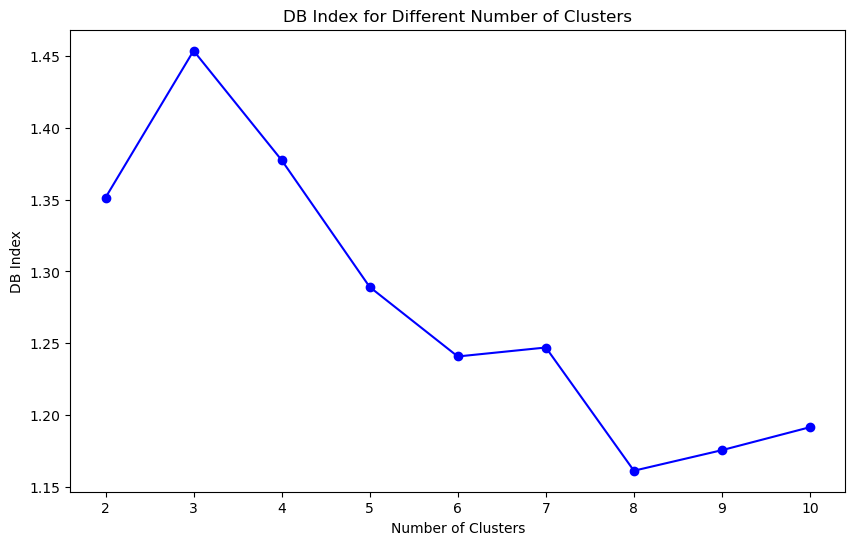

In [20]:
# Find optimal number of clusters using Davies-Bouldin Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_scaled)
    db_scores.append(davies_bouldin_score(segmentation_scaled, kmeans.labels_))

# Plot DB Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o', color='b')
plt.title('DB Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Choose optimal clusters and fit
optimal_clusters = np.argmin(db_scores) + 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(segmentation_scaled)

# Add cluster labels to data
lookalike_data['Cluster'] = clusters


The DB Index graph demonstrates that the clustering quality improves (lower DB Index values) as the number of clusters increases.
The optimal number of clusters appears to be 8, as the DB Index is at its lowest point in this range. This suggests that the clustering algorithm achieves better separation and compactness with these cluster counts.
Based on the DB Index, you likely selected 7 clusters for further analysis.

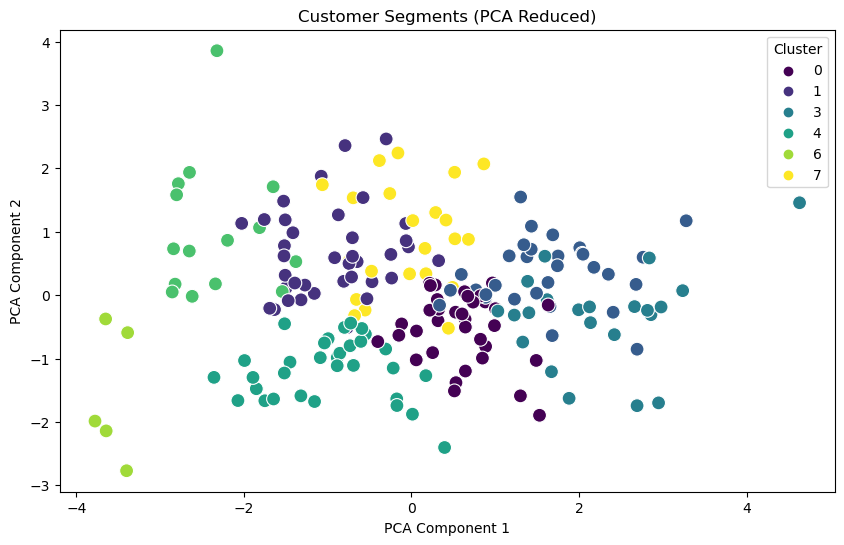

In [21]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(segmentation_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Customer Segments (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


Conclusion : 
The clusters are color-coded, showing how customers are grouped based on their similarities.
For example, customers in Cluster 0 (purple) are more compact,
while Cluster 4 (light green) is more spread out, meaning there’s more diversity within Cluster 4.

Some clusters (e.g., 1, 3, and 7) overlap, suggesting that these groups share common characteristics. This could mean that:
The features (data) used for clustering need improvement.
These customer groups naturally have similar behaviors and can be combined.